# Term Deposit Marketing - ML Project

---


**Project Overview:**

The goal of this project is to predict whether a customer will subscribe to a term deposit product based on data collected from a direct marketing campaign conducted by a European bank. The campaign involved multiple call attempts to customers, and the focus is on improving the success rate of such calls by identifying the most likely responders.

**Data Description:**

- **age**: Age of the customer
- **job**: Type of job (e.g., admin, technician, blue-collar)
- **marital**: Marital status (e.g., married, single)
- **education**: Level of education
- **default**: Has credit in default (yes/no)
- **balance**: Average yearly account balance in euros
- **housing**: Has a housing loan (yes/no)
- **loan**: Has a personal loan (yes/no)
- **contact**: Contact communication type (e.g., cellular, telephone)
- **day**: Last contact day of the month
- **month**: Last contact month (e.g., may, jul)
- **duration**: Duration of the last contact in seconds
- **campaign**: Number of contact attempts made during the campaign
- **Target (y)**: Indicates if the customer subscribed to a term deposit (yes/no)

**Objective:**

Build a classification model that predicts term deposit subscriptions with at least 81% accuracy, evaluated via 5-fold cross-validation. Additionally, identify key customer segments and features most associated with successful subscriptions, providing actionable insights for marketing prioritization and decision-making.


----

#### Summary of the Notebook:

##### 1. [Exploratory Data Analysis](#eda)
##### 2. [Experimenting with Prediction Models](#model-training)
##### 3. [Feature Engineering](#feature-engineering)
##### 4. [Feature Selection](#feature-selection)
##### 5. [Optimize the model and hyperparameters](#hyperopt)
##### 6. [Additional Feature Engineering steps](#additional-feature-engineering)
##### 7. [Exploring Features and Models Combinations](#exploring-features-and-models-combinations)
##### 8. [Minimal Predictive Feature Set](#minimal-predictive-feature-set)
##### 9. [Shift in Focus: from Accuracy to Business-Driven Metrics](#shift-in-focus)
##### [General Conclusion and Business Insights](#conclusion)



----

<a id="eda"></a>
### 1 - Exploratory Data Analysis

In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('term-deposit-marketing-2020.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        40000 non-null  int64 
 1   job        40000 non-null  object
 2   marital    40000 non-null  object
 3   education  40000 non-null  object
 4   default    40000 non-null  object
 5   balance    40000 non-null  int64 
 6   housing    40000 non-null  object
 7   loan       40000 non-null  object
 8   contact    40000 non-null  object
 9   day        40000 non-null  int64 
 10  month      40000 non-null  object
 11  duration   40000 non-null  int64 
 12  campaign   40000 non-null  int64 
 13  y          40000 non-null  object
dtypes: int64(5), object(9)
memory usage: 4.3+ MB


In [4]:
df.describe()

,age,balance,day,duration,campaign
count,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000
mean,40.544600,1274.277550,16.017225,254.824300,2.882175
std,9.641776,2903.769716,8.278127,259.366498,3.239051
min,19.000000,-8019.000000,1.000000,0.000000,1.000000
25%,33.000000,54.000000,8.000000,100.000000,1.000000
50%,39.000000,407.000000,17.000000,175.000000,2.000000
75%,48.000000,1319.000000,21.000000,313.000000,3.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000


#### **Check for duplicates and nulls:**

In [5]:
print(df.duplicated().sum())

0


In [6]:
nulls = df.isna().sum()
print(nulls)
print(f'\nTotal nulls: {nulls.sum()}')

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
y            0
dtype: int64

Total nulls: 0


#### **Target Variable Analysis:**

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt


Text(0.5, 1.0, 'Target Class Distribution')

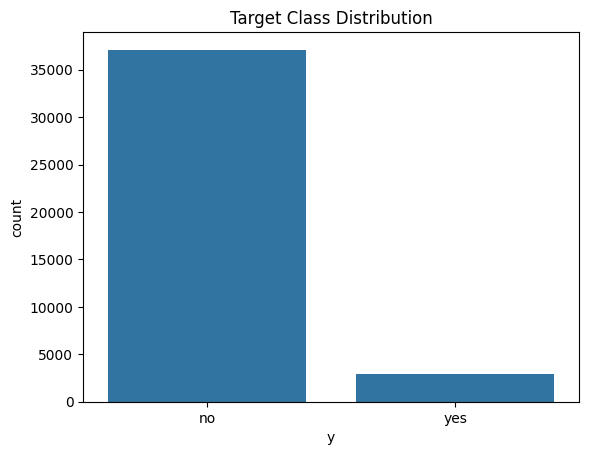

In [8]:
sns.countplot(x='y', data=df)
plt.title("Target Class Distribution")


In [9]:
# target values convertion
df['y'] = df['y'].map({'yes': 1, 'no':0})

In [10]:
df['y'].value_counts(normalize=True)

y
0    0.9276
1    0.0724
Name: proportion, dtype: float64

**Target Imbalance Observation:**

The target variable `y` is highly imbalanced, with approximately **92.76%** of the observations labeled as `no` (class 0) and only **7.24%** labeled as `yes` (class 1).  
This significant imbalance requires careful consideration, as relying solely on accuracy can be misleading. A model that always predicts the majority class would still achieve high accuracy without truly learning the underlying patterns.


#### **Features Analysis:**

Following, we present each feature representation:

##### **#1 - Age:**

In [11]:
def plot_facet_grid(feature, bins):
    g = sns.FacetGrid(df, col='y', height=5, aspect=1.2)
    g.map(sns.histplot, feature, bins=bins, color='#3498db', kde=False)
    g.set_titles(col_template='Target = {col_name}')
    g.set_axis_labels(feature, "Count")
    g.fig.suptitle(f"{feature} Distribution by Term Deposit Subscription", y=1.05)
    plt.tight_layout()
    plt.show()

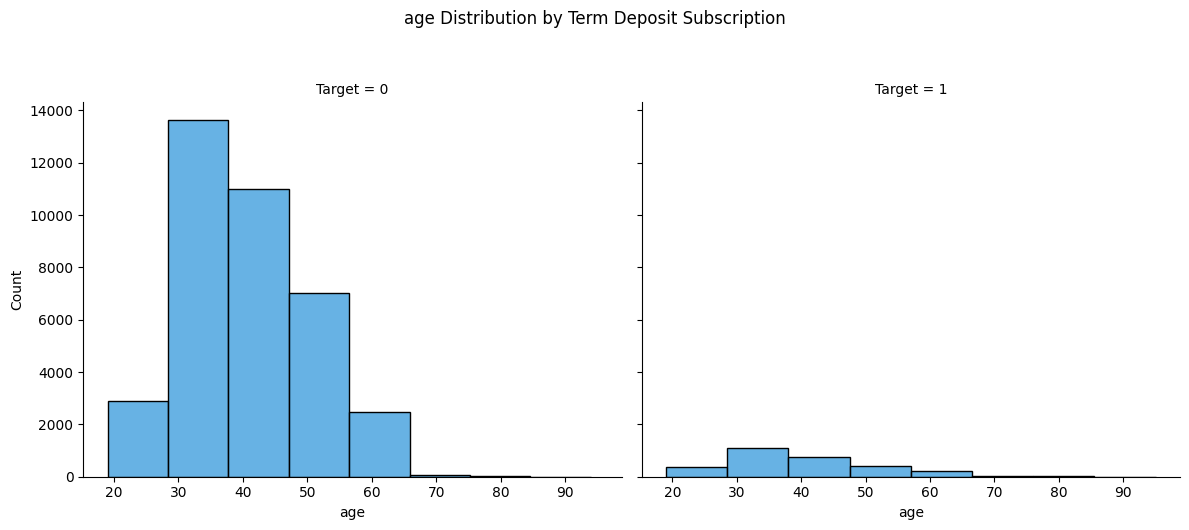

In [12]:
plot_facet_grid('age',8)

In [13]:
def plot_KDE(feature):
    # Kernel Density Estimation: estimate probability density function
    sns.kdeplot(data=df[df['y'] == 0], x=feature, label='No (0)', fill=True, color='#5DADE2')
    sns.kdeplot(data=df[df['y'] == 1], x=feature, label='Yes (1)', fill=True, color='#1ABC9C')
    plt.title(f"KDE of {feature} by Term Deposit Subscription")
    plt.xlabel(feature)
    plt.ylabel("Density")
    plt.legend()
    plt.show()


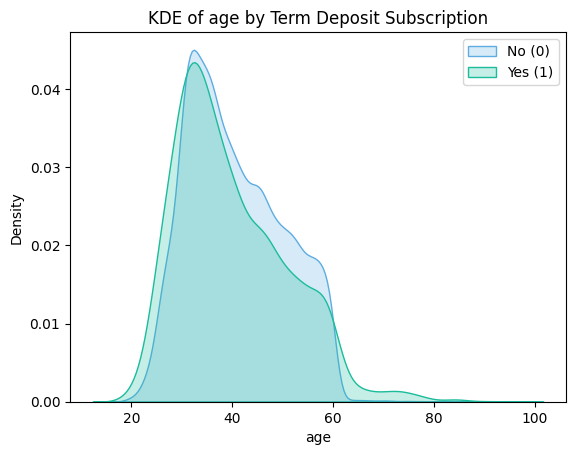

In [14]:
plot_KDE('age')

In [15]:
def plot_TargetbyCat(feature, bar_height=0.5, height_per_row=0.6):
    job_counts_abs = pd.crosstab(df[feature], df['y']).sort_values(by=1, ascending=False)
    jobs = job_counts_abs.index
    counts_no = job_counts_abs[0]
    counts_yes = job_counts_abs[1]

    # Dynamically set height based on number of categories
    dynamic_height = max(4, len(jobs) * height_per_row)
    fig, ax = plt.subplots(figsize=(12, dynamic_height))

    bar_min_width = 200

    bar_no = ax.barh(jobs, counts_no, color='#5DADE2', label='No (0)', height=bar_height)
    bar_yes = ax.barh(jobs, counts_yes, left=counts_no, color='#1ABC9C', label='Yes (1)', height=bar_height)

    for i, (no, yes) in enumerate(zip(counts_no, counts_yes)):
        total = no + yes
        yes_pct = f'{yes / total:.1%}'
        no_pct = f'{no / total:.1%}'

        ax.text(no / 2, i, no_pct, va='center', ha='center', color='white', fontsize=9)

        if yes > bar_min_width:
            ax.text(no + yes / 2, i, yes_pct, va='center', ha='center', color='white', fontsize=9)
        else:
            ax.text(no + yes + 50, i, yes_pct, va='center', ha='left', color='black', fontsize=9)

    ax.set_xlabel("Number of Records")
    ax.set_title(f"Term Deposit Subscriptions by {feature} (Absolute Count & Proportion)")
    ax.legend(loc='upper right')
    plt.tight_layout()
    plt.show()


##### **#2 - Job:**

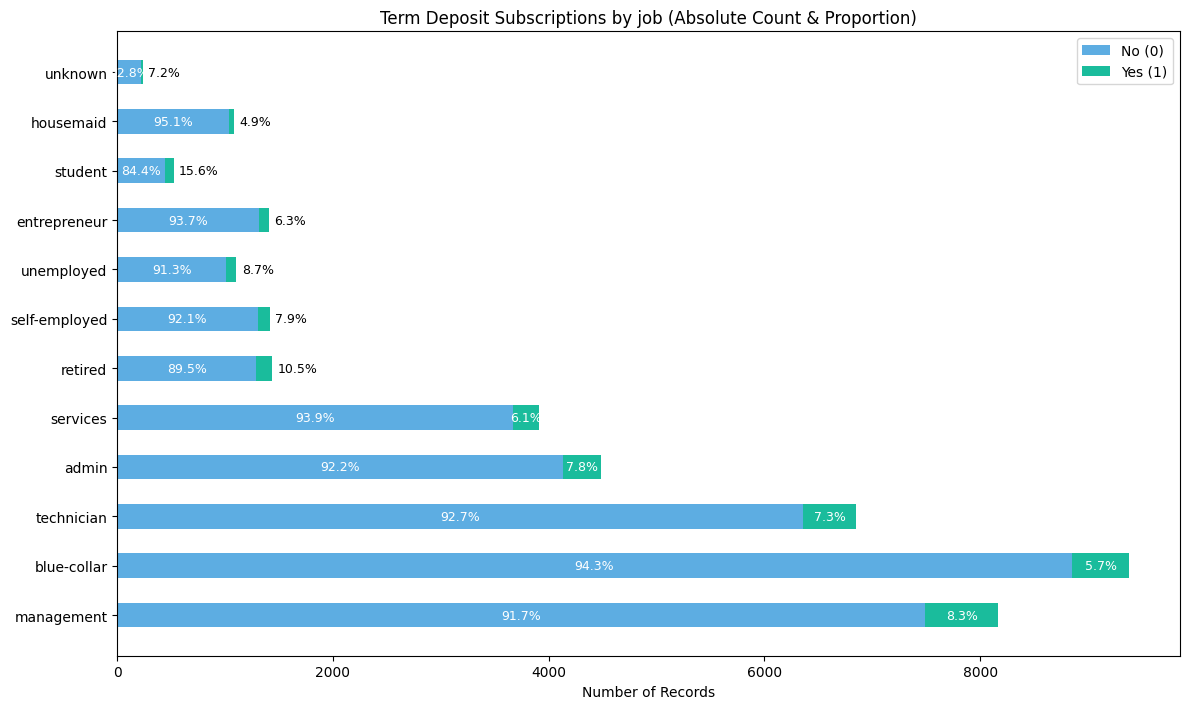

In [16]:
plot_TargetbyCat('job')

##### **#3 - Marital:**

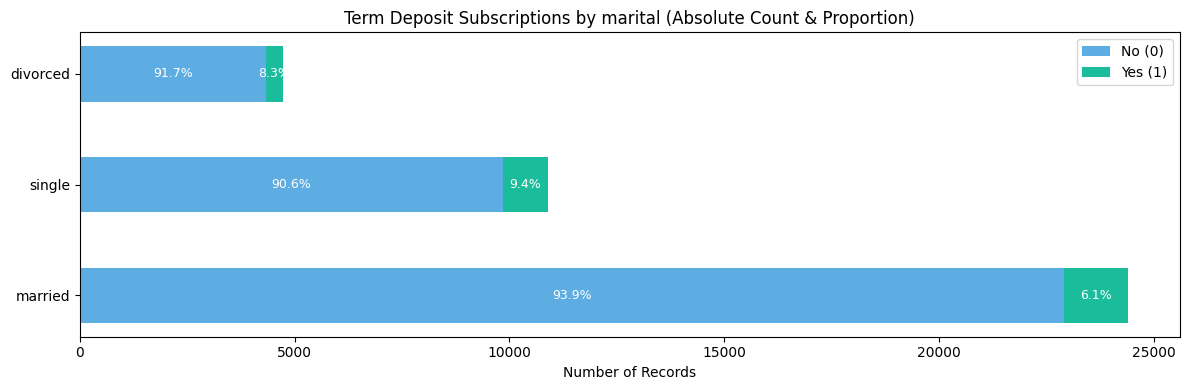

In [17]:
plot_TargetbyCat('marital')

##### **#4 - Education:**

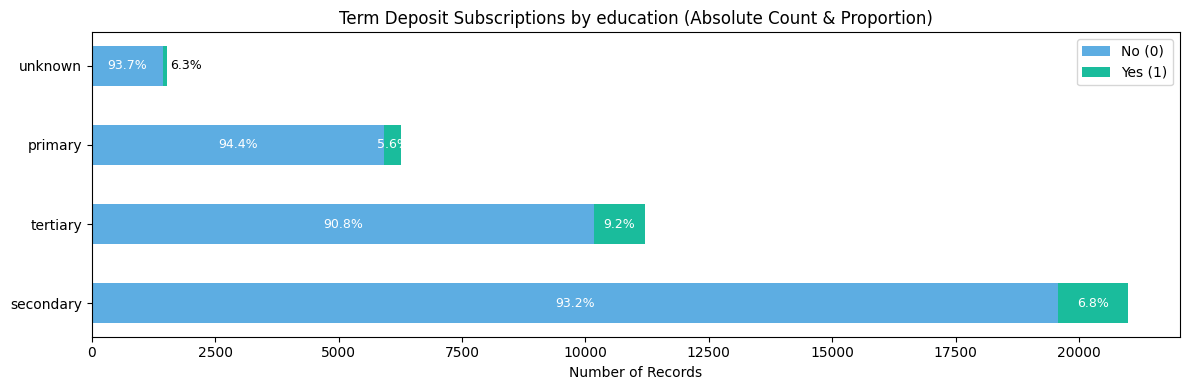

In [18]:
plot_TargetbyCat('education')

##### **#5 - Default:**

Has credit in default? (yes/no)


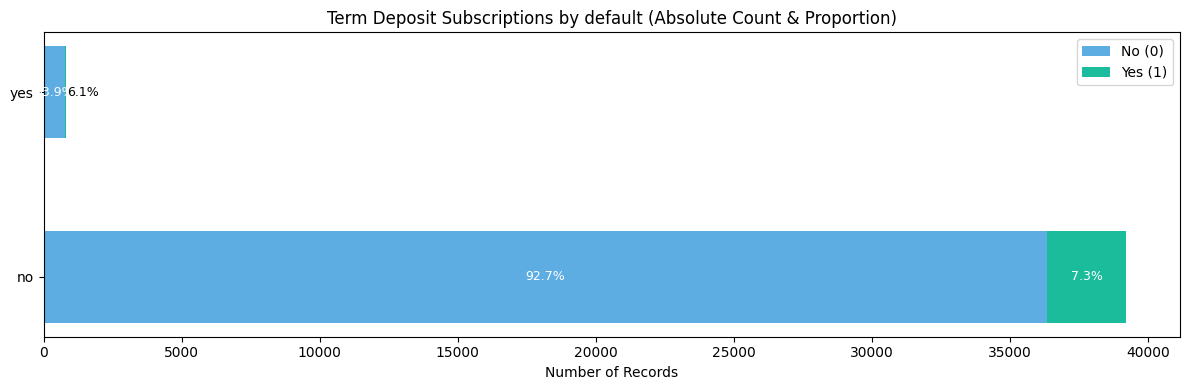

In [19]:
plot_TargetbyCat('default')

##### **#6 - Balance**

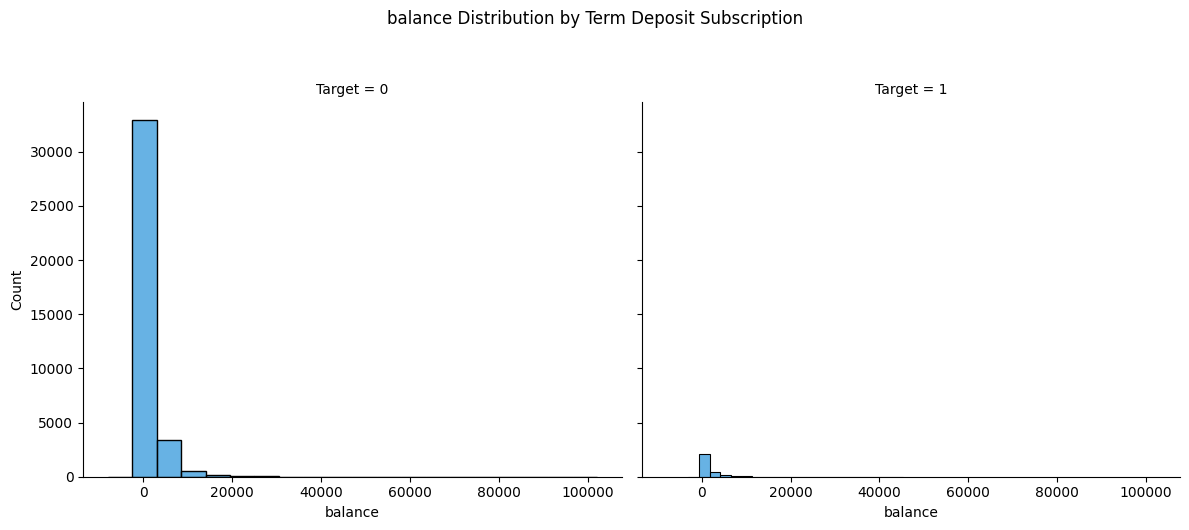

In [20]:
plot_facet_grid('balance',20)

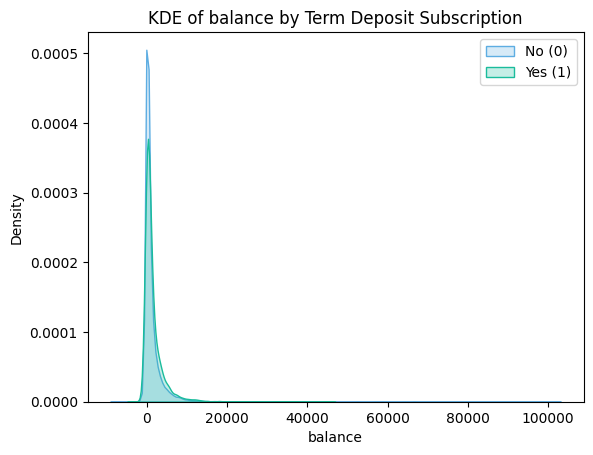

In [21]:
plot_KDE('balance')

In [22]:
df['balance'].min(), df['balance'].max()

(np.int64(-8019), np.int64(102127))

In [23]:
df[df['balance'] < 0].shape[0]

3731

Observation: Presence of outliers. Strong right skew.

##### **#7 - Housing**

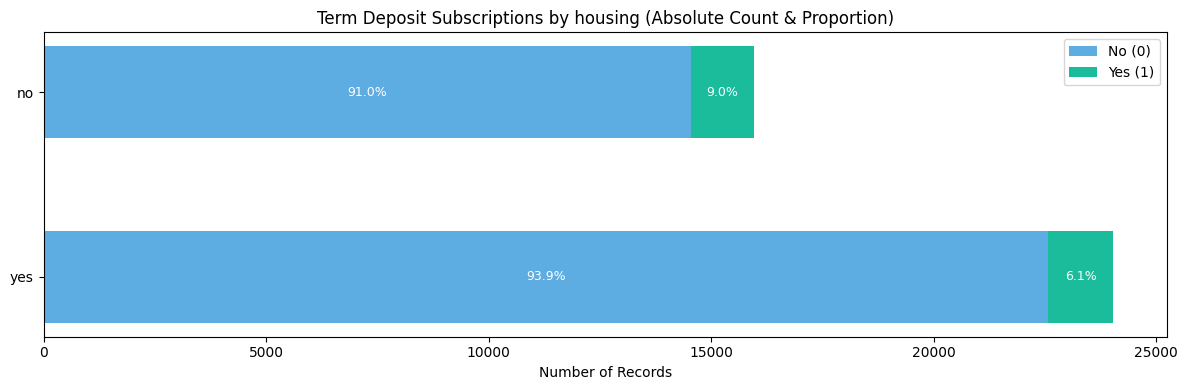

In [24]:
plot_TargetbyCat('housing')

##### **#8 - Loan**

loan: Has a personal loan (yes/no)

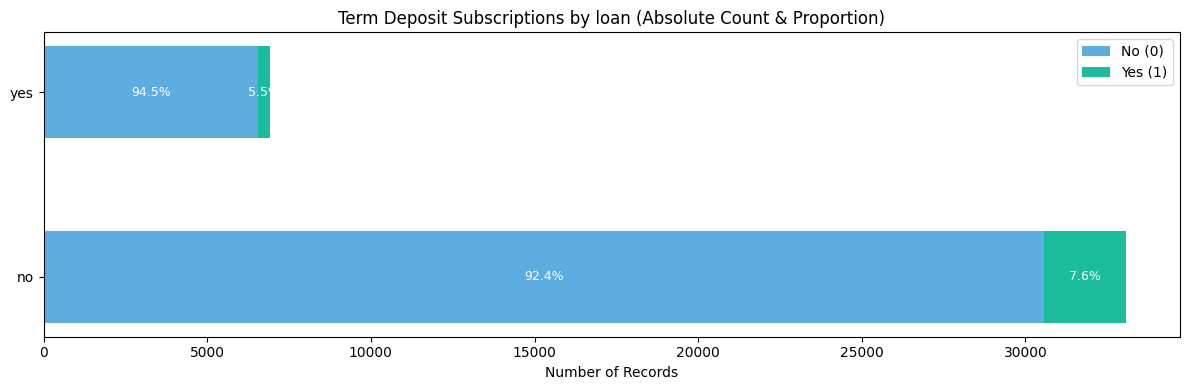

In [25]:
plot_TargetbyCat('loan')

##### **#9 - Contact**

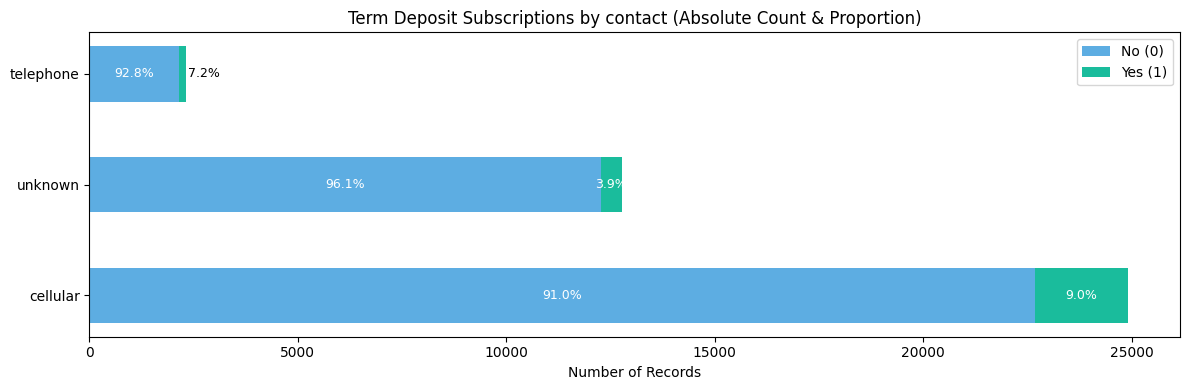

In [26]:
plot_TargetbyCat('contact')

##### **#10 - Day**

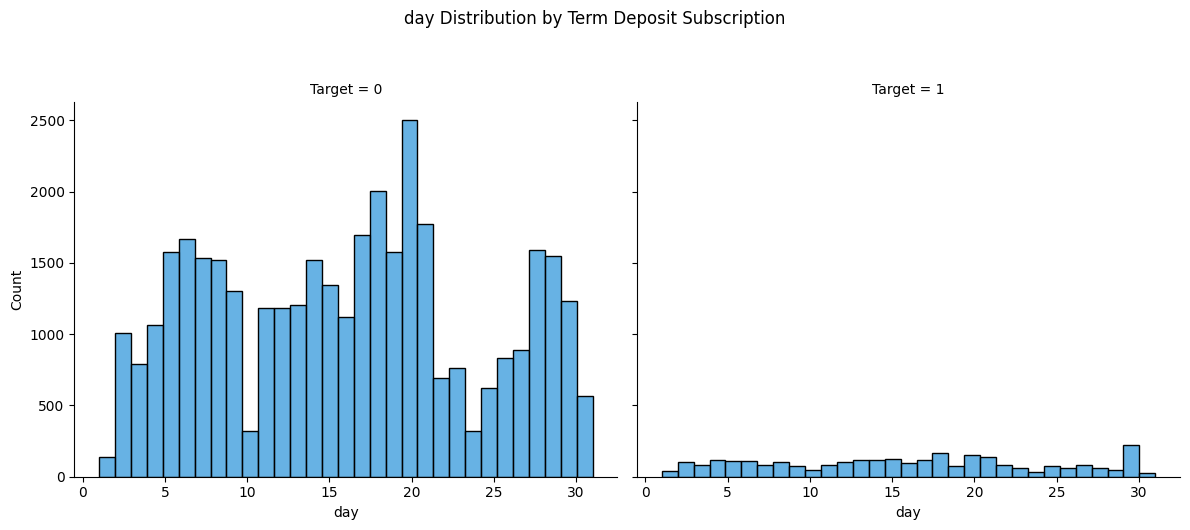

In [27]:
plot_facet_grid('day',31)

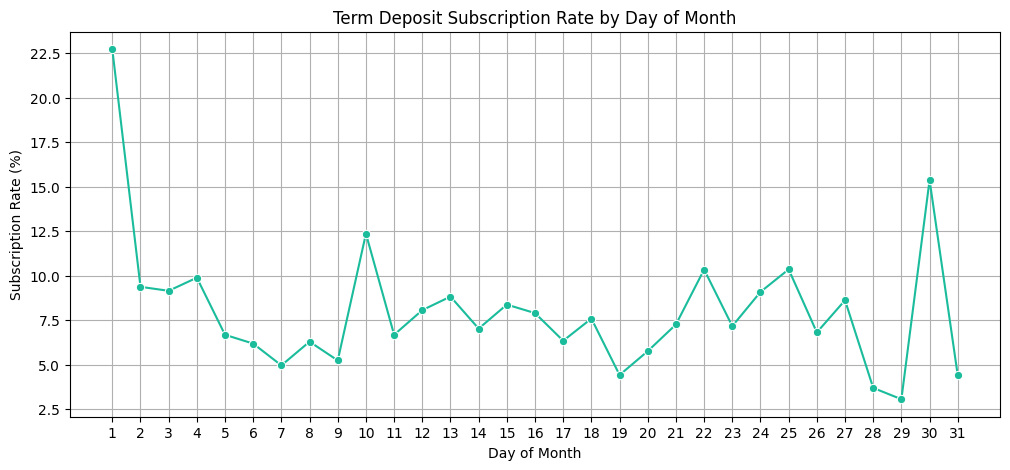

In [28]:
conversion_by_day = df.groupby('day')['y'].mean() * 100

plt.figure(figsize=(12, 5))
sns.lineplot(x=conversion_by_day.index, y=conversion_by_day.values, marker='o', color='#1ABC9C')
plt.title("Term Deposit Subscription Rate by Day of Month")
plt.xlabel("Day of Month")
plt.ylabel("Subscription Rate (%)")
plt.grid(True)
plt.xticks(range(1, 32))
plt.show()


**Observation**: The subscription rate shows clear variation across the month, with peaks at the beginning and end of the month (e.g., Day 1 and Day 30). This suggests potential behavioral or campaign-driven effects, making the day of month a potentially valuable feature for modeling.

##### **#11 - Month**

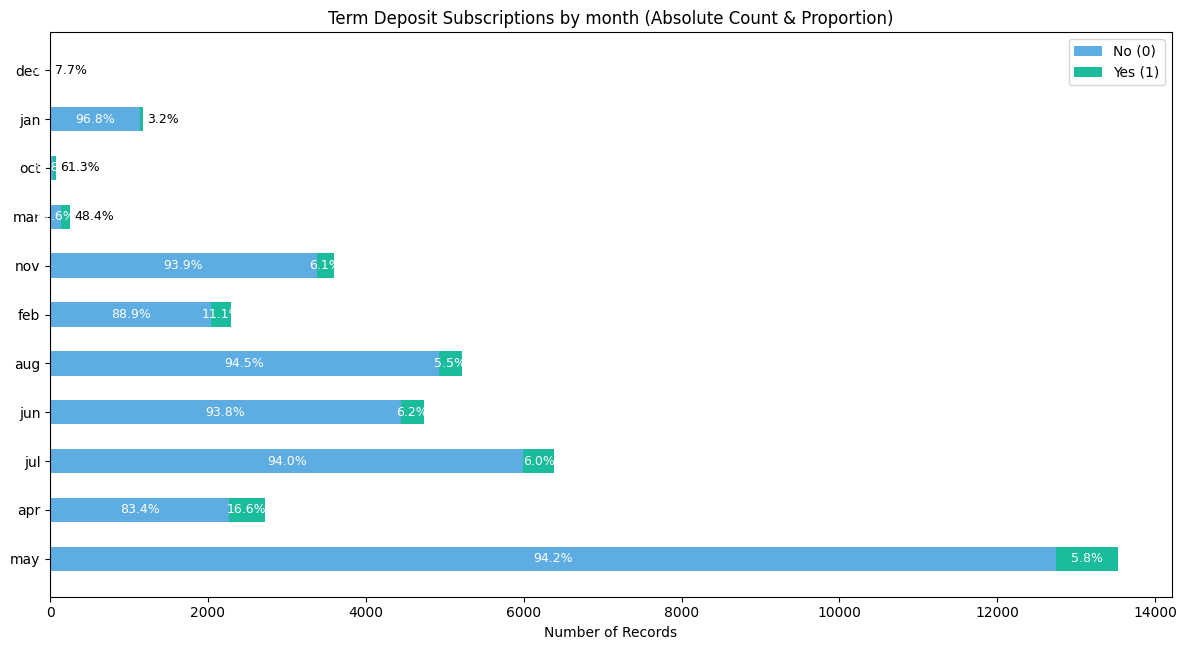

In [29]:
plot_TargetbyCat('month')

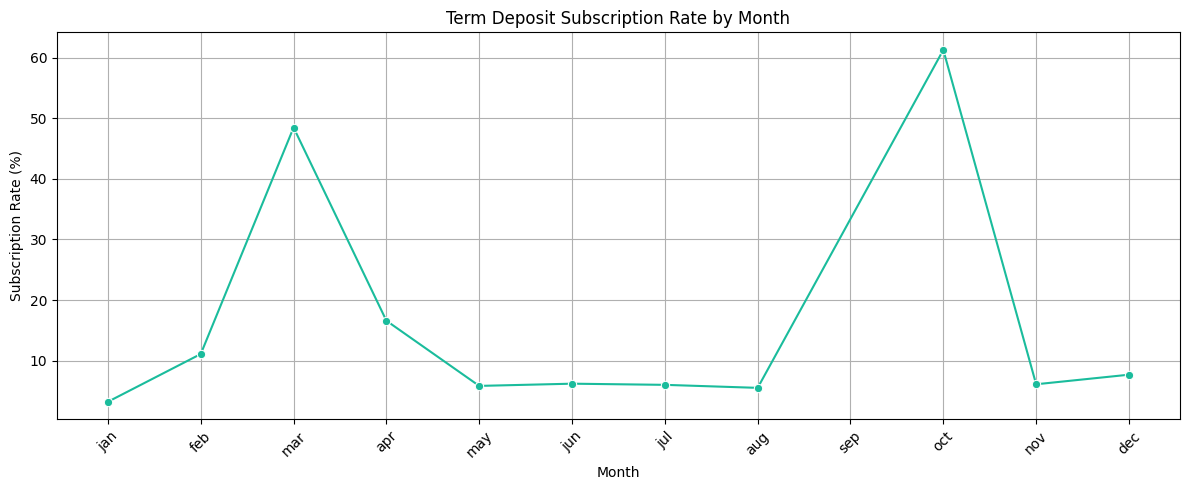

In [30]:
month_order = ['jan', 'feb', 'mar', 'apr', 'may', 'jun',
               'jul', 'aug', 'sep', 'oct', 'nov', 'dec']
df['month'] = df['month'].str.lower()
df['month'] = pd.Categorical(df['month'], categories=month_order, ordered=True)
conversion_by_month = df.groupby('month',observed=True)['y'].mean() * 100

plt.figure(figsize=(12, 5))
sns.lineplot(x=conversion_by_month.index, y=conversion_by_month.values, marker='o', color='#1ABC9C')
plt.title("Term Deposit Subscription Rate by Month")
plt.xlabel("Month")
plt.ylabel("Subscription Rate (%)")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


**Observation**:
Although March and October show unusually high subscription rates, these months have very few records, which may limit the reliability of their impact. To avoid introducing misleading patterns. Later on we will apply a one-hot encoding strategy, ensuring each month is treated independently without assuming ordinal relationships.

##### **#12 - Duration**

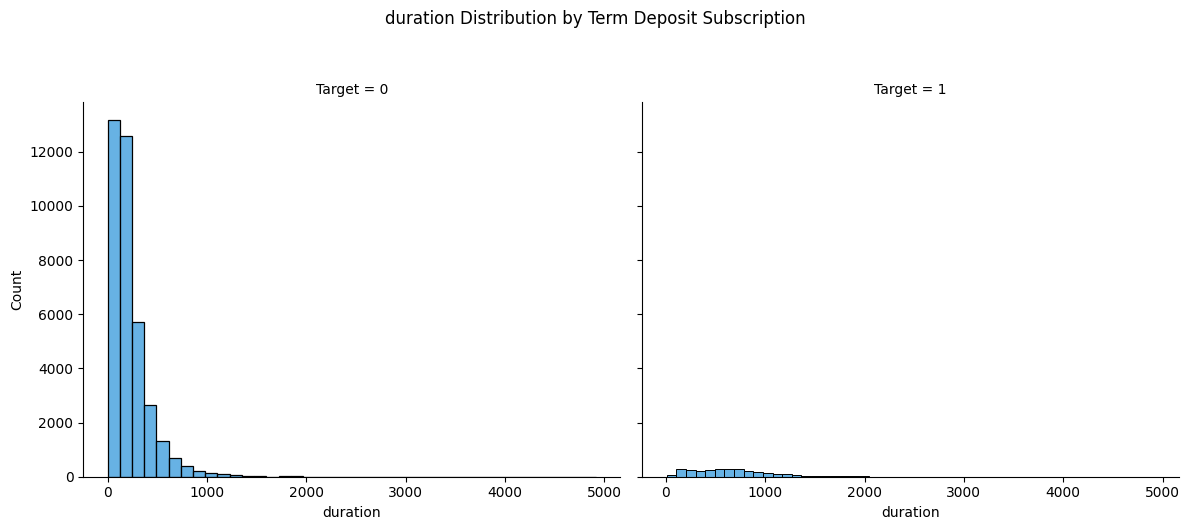

In [31]:
plot_facet_grid('duration',40)

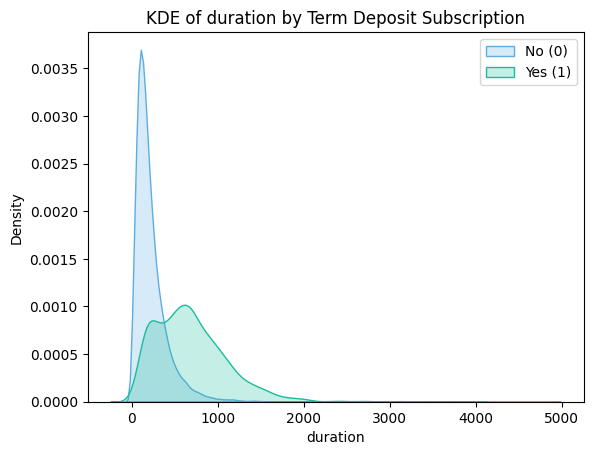

In [32]:
plot_KDE('duration')

In [33]:
def plot_callDurationDistByFeature(feature):

    plt.figure(figsize=(15, 6))
    ax = sns.boxplot(x=feature, y='duration', hue='y', data=df, palette=['#5DADE2', '#1ABC9C'])
    plt.title(f"Call Duration Distribution by {feature} and Subscription Outcome")
    plt.xlabel("Day of Month" if feature=='day' else feature)
    plt.ylabel("Call Duration (seconds)")
    
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, ['No', 'Yes'], title='Subscribed')
    
    plt.tight_layout()
    plt.show()


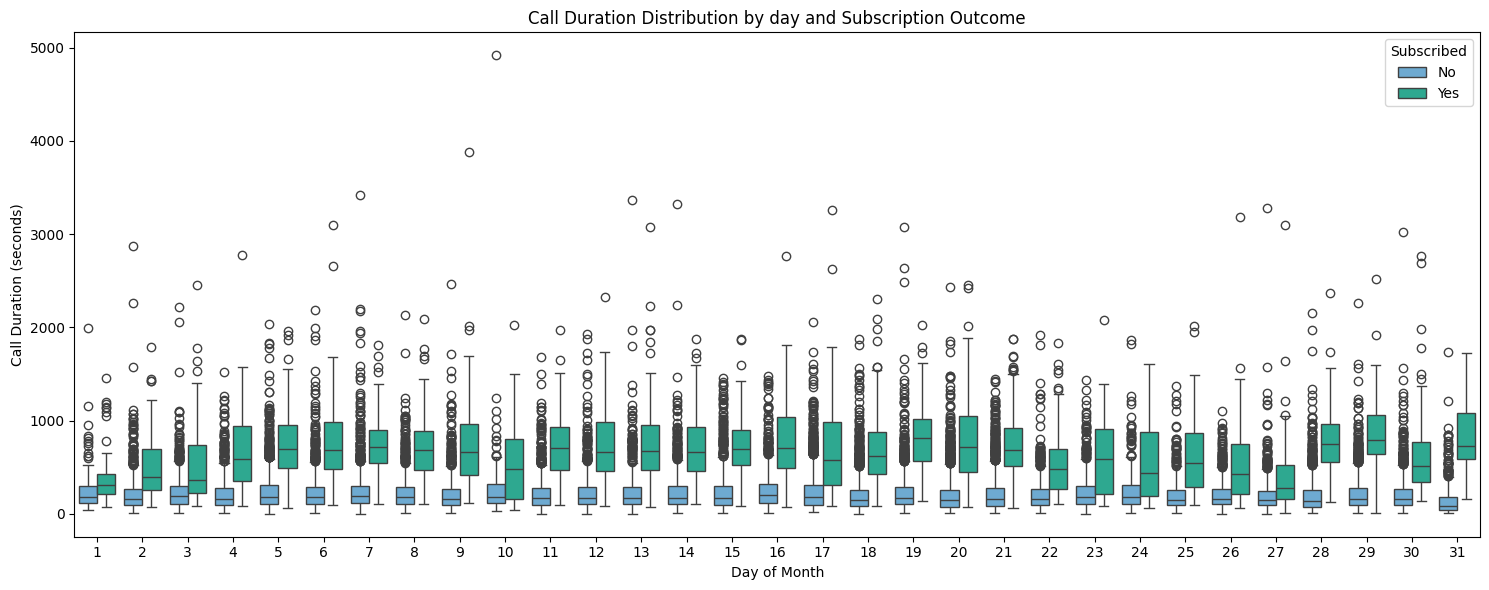

In [34]:
plot_callDurationDistByFeature('day')

##### **#13 - Campaign**

Number of contact attempts made during the campaign


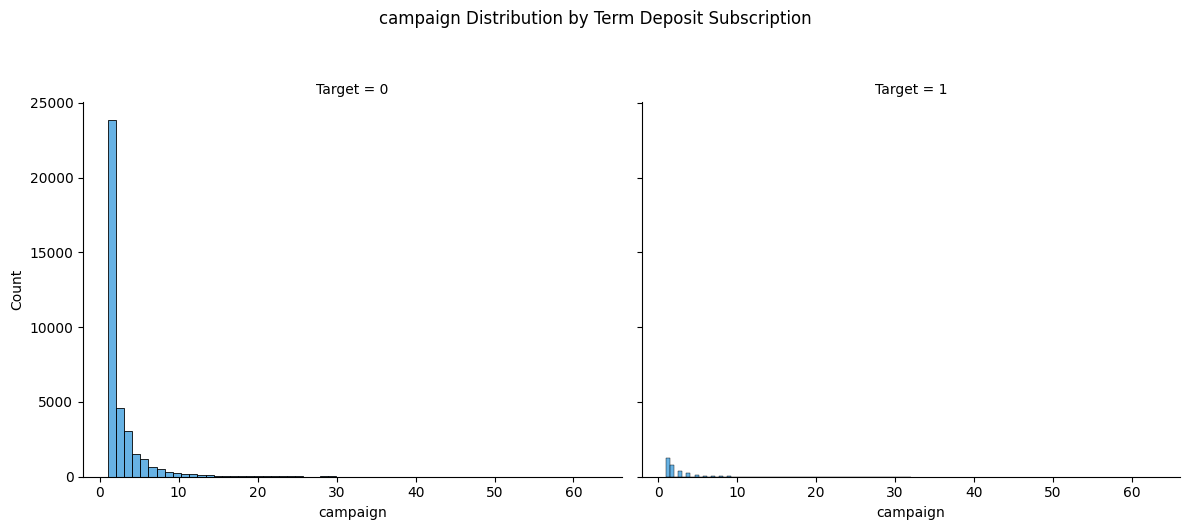

In [35]:
plot_facet_grid('campaign',60)

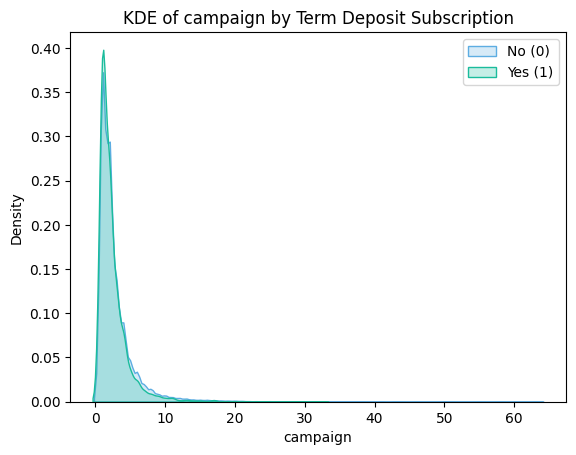

In [36]:
plot_KDE('campaign')

----

### Engineering and Encoding Strategy per Feature

| Feature     | Type                        | Encoding Strategy                                                                 |
|-------------|-----------------------------|-----------------------------------------------------------------------------------------------|
| `age`       | Continuous                  | Keep as-is, but use normalization                                           |
| `balance`   | Continuous (with outliers)  | Apply log transformation because of high occurence of outliers                                |
| `day`       | Ordinal (1–31)              | Keep as-is: behavioral signal observed at beginning and end of month                     |
| `duration`  | Continuous (long-tailed)    | Apply log transformation                                              |
| `campaign`  | Count / Discrete            | Binning: (1 call, 2, 3, 4-5, 6+)
| `month`     | Categorical (cyclical)      | One-hot-encoding                                                                               |
| `job`       | Nominal Categorical         | One-Hot Encoding                                                                              |
| `marital`   | Nominal Categorical         | One-Hot Encoding                                                          |
| `education` | Ordinal Categorical         | Ordinal Encoding                                 |
| `default`   | Binary                      | Binary Encoding                                                             |
| `housing`   | Binary                      | Binary Encoding                                                              |
| `loan`      | Binary                      | Binary Encoding                                                              |
| `contact`   | Nominal Categorical         | One-Hot Encoding                                                |
| `y`         | Binary (Target)             | Binary Encoding                                                              |


**'age' feature:**

In [37]:
from sklearn.preprocessing import StandardScaler

In [38]:
scaler = StandardScaler()
df['age_t'] = scaler.fit_transform(df[['age']])


**'balance' feature:**

To preserve the meaningful distinction between positive and negative balances, we decomposed the original balance feature into two components:
- `balance_sign`: captures the direction of the balance (negative, zero, or positive)
- `balance_log_z`: applies a log transformation followed by z-score normalization to the absolute value of the balance
  
This approach retains the financial interpretation of debt vs. savings while normalizing the scale of balance magnitudes for modeling.

In [39]:
import numpy as np

In [41]:
df['balance_sign'] = np.sign(df['balance'])  # -1, 0, 1
df['balance_t'] = np.log(df['balance'].abs()+1)
df['balance_t'] = scaler.fit_transform(df[['balance_t']])

**'day' feature:**

The spike in subscription rates on days 1, 2, 3, 29, 30, and 31 could reflect psychological, financial, or procedural patterns:
- People may feel more decisive at the beginning or end of a month.
- They might have just received their salary or are resetting plans for the new month.
- It's also possible that agents prioritize high-probability leads on those days.

In [42]:
df['day_group'] = df['day'].apply(lambda x: 'edge_days' if x in [1, 2, 3, 29, 30, 31] else 'middle_days')


In [43]:
# one-hot encode the column
day_group_dummies = pd.get_dummies(df['day_group'], prefix='day_group')
# concatenate the DF
df = pd.concat([df, day_group_dummies], axis=1)
# drop the support column, not longer needed
df.drop(columns='day_group', inplace=True)


**'duration' feature:**

The duration feature (last contact length in seconds) shows a strong relationship with the target variable. However, as this value is only known after the call ends, it may cause data leakage if used in a real-time prediction context.

In this project, we include duration for post-hoc modeling and interpretability purposes. A log transformation followed by z-score normalization is applied to reduce skewness and improve model stability.


In [44]:
df['duration_t'] = df['duration'].replace(0, 1)
df['duration_t'] = np.log(df['duration_t'])
df['duration_t'] = scaler.fit_transform(df[['duration_t']])

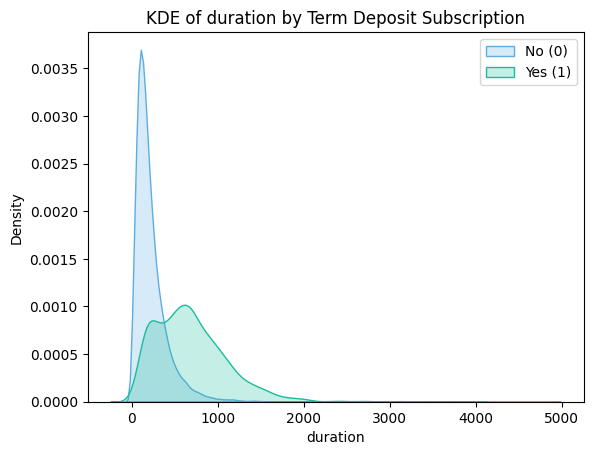

In [45]:
plot_KDE('duration')

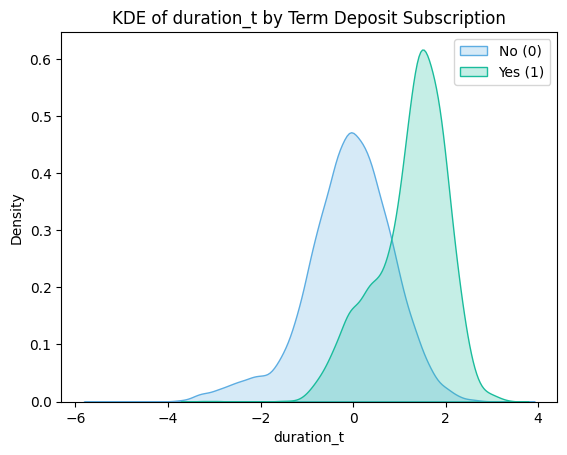

In [46]:
plot_KDE('duration_t')

**'campaign' feature:**

In [47]:
# binning
df['campaign_group'] = pd.cut(df['campaign'],
                               bins=[0, 1, 2, 3, 5, np.inf],
                               labels=['1 contact', '2', '3', '4-5', '6+'],
                               right=True)

In [48]:
campaign_group_dummies = pd.get_dummies(df['campaign_group'], prefix='campaign_group')
df = pd.concat([df, campaign_group_dummies], axis=1)
df.drop(columns='campaign_group', inplace=True)

**'month' feature:**

In [49]:
month_dummies = pd.get_dummies(df['month'], prefix='month')
df = pd.concat([df, month_dummies], axis=1)

**'job' feature:**

In [50]:
job_dummies = pd.get_dummies(df['job'], prefix='job')
df = pd.concat([df, job_dummies], axis=1)

**'marital' feature:**

In [51]:
marital_dummies = pd.get_dummies(df['marital'], prefix='marital')
df = pd.concat([df, marital_dummies], axis=1)

**'education' feature:**

In [52]:
education_map = {'unknown': -1, 'primary': 0, 'secondary': 1, 'tertiary': 2}
df['education_ord'] = df['education'].map(education_map)


**'default', 'housing', 'loan' features:**

In [53]:
binary_map = {'no': 0, 'yes': 1}
df['default_bin'] = df['default'].map(binary_map)
df['housing_bin'] = df['housing'].map(binary_map)
df['loan_bin'] = df['loan'].map(binary_map)


**'contact' features:**

In [54]:
contact_dummies = pd.get_dummies(df['contact'], prefix='contact')
df = pd.concat([df, contact_dummies], axis=1)


----

#### Filter the feature columns

In [56]:
df.columns

Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'y', 'age_t',
       'balance_sign', 'balance_t', 'day_group_edge_days',
       'day_group_middle_days', 'duration_t', 'campaign_group_1 contact',
       'campaign_group_2', 'campaign_group_3', 'campaign_group_4-5',
       'campaign_group_6+', 'month_jan', 'month_feb', 'month_mar', 'month_apr',
       'month_may', 'month_jun', 'month_jul', 'month_aug', 'month_sep',
       'month_oct', 'month_nov', 'month_dec', 'job_admin', 'job_blue-collar',
       'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired',
       'job_self-employed', 'job_services', 'job_student', 'job_technician',
       'job_unemployed', 'job_unknown', 'marital_divorced', 'marital_married',
       'marital_single', 'education_ord', 'default_bin', 'housing_bin',
       'loan_bin', 'contact_cellular', 'contact_telephone', 'contact_unknown'],
      dtype='object')

In [57]:
X = df[[
    'age_t', 'balance_t', 'duration_t',

    'day_group_edge_days', 'day_group_middle_days',

    'campaign_group_1 contact', 'campaign_group_2', 'campaign_group_3',
    'campaign_group_4-5', 'campaign_group_6+',

    'month_jan', 'month_feb', 'month_mar', 'month_apr', 'month_may',
    'month_jun', 'month_jul', 'month_aug', 'month_sep',
    'month_oct', 'month_nov', 'month_dec',

    'job_admin', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid',
    'job_management', 'job_retired', 'job_self-employed', 'job_services',
    'job_student', 'job_technician', 'job_unemployed', 'job_unknown',

    'marital_divorced', 'marital_married', 'marital_single',

    'education_ord',

    'default_bin', 'housing_bin', 'loan_bin',

    'contact_cellular', 'contact_telephone', 'contact_unknown'
]]


In [58]:
y = df['y']

In [59]:
X.shape, y.shape

((40000, 44), (40000,))

----

### Baseline

#### Split the dataset

In [98]:
print(f'Number of negative rows: {df[df['y'] == 1].shape[0]} out of {df.shape[0]}')

Number of negative rows: 2896 out of 40000


*Sampling Strategy*

Given the significant class imbalance in the target variable (≈7.2% positive class), we will apply a combined resampling strategy to balance the training data. Specifically, we first will upsample the minority class to 50% of the majority class using RandomOverSampler, then downsample the majority class to match this new size using RandomUnderSampler. This will balanced the dataset while preserving more training examples than full downsampling, and reduced the risk of overfitting often associated with aggressive upsampling.

The sampling strategy will be only applied for the trainig set, the test set will keep the original balance: Train on balanced → Test on imbalanced

In [73]:
from sklearn.model_selection import train_test_split
import random

In [75]:
#seed = random.randint(10000,99999)
seed = 23
#seed

In [76]:
# Hold out a test set (stratified, imbalanced)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=seed, test_size=0.2)


In [77]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline


In [78]:
over = RandomOverSampler(sampling_strategy=0.5)
under = RandomUnderSampler(sampling_strategy=1.0)


In [79]:
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps)
X_resampled, y_resampled = pipeline.fit_resample(X_train, y_train)


Double check shapes and balances:

In [80]:
print(f'{X_train.shape=} {X_test.shape=} {X_resampled.shape=}')

X_train.shape=(32000, 44) X_test.shape=(8000, 44) X_resampled.shape=(29682, 44)


In [81]:
y_train.value_counts(normalize=True)

y
0    0.927594
1    0.072406
Name: proportion, dtype: float64

In [82]:
y_resampled.value_counts(normalize=True)

y
0    0.5
1    0.5
Name: proportion, dtype: float64

Baseline Models

In [84]:
from lazypredict.Supervised import LazyClassifier
from sklearn.model_selection import train_test_split

In [87]:
clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None, random_state=seed)
models, predictions = clf.fit(X_resampled, X_test, y_resampled, y_test)

# Show sorted results
print(models.sort_values(by='Accuracy', ascending=False))

  0%|          | 0/31 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 14841, number of negative: 14841
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000504 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 589
[LightGBM] [Info] Number of data points in the train set: 29682, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
                               Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                           
DummyClassifier                    0.93               0.50     0.50      0.89   
ExtraTreesClassifier               0.92               0.69     0.69      0.92   
RandomForestClassifier             0.91               0.75     0.75      0.92   
BaggingClassifier                  0.90               0.70     0.70      0.90   
ExtraTreeClas

#### Note on DummyClassifier:
Although the DummyClassifier achieves high accuracy (~93%) by always predicting the majority class (0), 
its Balanced Accuracy is only 0.50, revealing that it completely fails to identify the minority class (1).
Balanced Accuracy provides a more truthful measure of performance for highly inbalanced sets.


Let's check how it performs with cross-validation accuracy using 5 folds on the same split

In [88]:
from sklearn.model_selection import StratifiedKFold
from lazypredict.Supervised import LazyClassifier
import pandas as pd

# Setup Stratified 5-Fold CV
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Store accuracy scores from each fold
scores = []

for train_idx, val_idx in kf.split(X_resampled, y_resampled):
    X_train_cv, X_val_cv = X_resampled.iloc[train_idx], X_resampled.iloc[val_idx]
    y_train_cv, y_val_cv = y_resampled.iloc[train_idx], y_resampled.iloc[val_idx]

    clf = LazyClassifier(verbose=0, ignore_warnings=True)
    models, _ = clf.fit(X_train_cv, X_val_cv, y_train_cv, y_val_cv)

    scores.append(models['Accuracy'])

# Combine fold scores into a DataFrame
scores_df = pd.concat(scores, axis=1)
scores_df.columns = [f'Fold {i+1}' for i in range(len(scores))]

# Compute Mean and Std Dev
scores_df['Mean Accuracy'] = scores_df.mean(axis=1)
scores_df['Std Accuracy'] = scores_df.std(axis=1)

# Sort by Mean Accuracy
scores_df = scores_df.sort_values('Mean Accuracy', ascending=False)

# Show result
display(scores_df[['Mean Accuracy', 'Std Accuracy']])


  0%|          | 0/31 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 11873, number of negative: 11872
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000441 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 589
[LightGBM] [Info] Number of data points in the train set: 23745, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500021 -> initscore=0.000084
[LightGBM] [Info] Start training from score 0.000084


  0%|          | 0/31 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 11872, number of negative: 11873
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000444 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 589
[LightGBM] [Info] Number of data points in the train set: 23745, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499979 -> initscore=-0.000084
[LightGBM] [Info] Start training from score -0.000084


  0%|          | 0/31 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 11873, number of negative: 11873
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000364 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 589
[LightGBM] [Info] Number of data points in the train set: 23746, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


  0%|          | 0/31 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 11873, number of negative: 11873
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000396 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 589
[LightGBM] [Info] Number of data points in the train set: 23746, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


  0%|          | 0/31 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 11873, number of negative: 11873
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000336 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 589
[LightGBM] [Info] Number of data points in the train set: 23746, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


,Mean Accuracy,Std Accuracy
Model,,
ExtraTreesClassifier,0.97,0.00
RandomForestClassifier,0.96,0.00
BaggingClassifier,0.96,0.00
DecisionTreeClassifier,0.95,0.00
ExtraTreeClassifier,0.95,0.00
XGBClassifier,0.91,0.00
KNeighborsClassifier,0.89,0.00
LabelPropagation,0.89,0.00
LabelSpreading,0.88,0.00
